# Simple SIR Model

Here we use the tabular epidemic model framework and some base rules to create a simple epidemic model and run it both deterministically and with a number of stochastic simulations. 

First we do some imports/setup.

In [33]:
import tabularepimdl as tepi

import pandas as pd
import numpy as np

## Defining a Population

The first thing we need to do is create a population in tabular format. The population is just a pandas data frame with disease state columns (`InfState`), a columns telling how many people have the signature represented by each row (`N`) and a column representing time (`T`). We will start with one person infected and everyone else susceptible.

In [34]:
population = pd.DataFrame({
    'InfState' : pd.Categorical(['S','I'], categories=['S','I','R']),
    'N' : [999, 1],
    'T': 0
})

## Defining an Epidemic Model

We now will define the epidemic model. The model will consist of two rules, one representing the infection process, and one representing the recovery process. This first version will be deterministic and consist of:
- a frequncy dependent infection process with $\beta$ of 0.5 using default values for S and I states and S moving to I.
- a recovery rule where folks stay infectious an average of 4 days
giving us an $R_0$ of 2.


In [35]:
infect_rule = tepi.SimpleInfection(beta=0.5, column='InfState')
recover_rule = tepi.SimpleTransition(column='InfState', from_st='I', to_st='R', rate=0.25)
epi_mdl = tepi.EpiModel(init_state = population ,rules=[infect_rule, recover_rule])



## Running the Deterministic Epidemic Model

We now run the epidemic by repeatedly calling `do_timestep` with an appropriately small step size.

In [36]:
for i in range(400):
    epi_mdl.do_timestep(dt=0.25)

Now we can plot the results.

In [37]:
import plotly.express as px

epi_fig = px.line(epi_mdl.full_epi, x="T", y="N", color="InfState")
epi_fig.show()

## Making and Running a Stochastic Epidemic Model

There are two  ways to set up a stochastic epidemic model. One is to specify stochasticity at the rule level, the other is to do so at the model level. Here we will use the same rules as before and set up stochasticity at the model level. 

In [48]:
stoch_epi_mdl = tepi.EpiModel(init_state=population, rules = [infect_rule, recover_rule], stoch_policy="stochastic")

Running a single model is the same as for deterministic

In [49]:
np.random.seed(2) #just to guarantee an epidemic

for i in range(400):
    stoch_epi_mdl.do_timestep(dt=0.25)

epi_fig = px.line(stoch_epi_mdl.full_epi, x="T", y="N", color="InfState")
epi_fig.show()

Using the 'reset' function makes it ease for us to run multiple simulations.

In [51]:
#Do 100 simulations concatenating together. 
all_sims = []

for i in range(20):
    stoch_epi_mdl.reset()
    for j in range(400):
        stoch_epi_mdl.do_timestep(dt=0.25)
    tmp = stoch_epi_mdl.full_epi
    tmp['sim'] = i
    all_sims = all_sims + [tmp]

all_sims = pd.concat(all_sims)



In [52]:
from plotnine import *
from plotly.tools import mpl_to_plotly as ggplotly

all_sims.groupby('sim')
stoch_fig = px.line(all_sims, x="T",y="N", color="InfState")
stoch_fig.update_traces(opacity=0.25)
stoch_fig.show()
all_sims.reset_index()


,index,InfState,N,T,sim
0,0,S,999,0.00,0
1,1,I,1,0.00,0
2,0,I,1,0.25,0
3,2,S,999,0.25,0
4,0,I,1,0.50,0
...,...,...,...,...,...
17871,2,S,999,99.50,19
17872,1,R,1,99.75,19
17873,2,S,999,99.75,19
17874,1,R,1,100.00,19


In [12]:
%load_ext rpy2.ipython


`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


/home/justin/anaconda3/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame


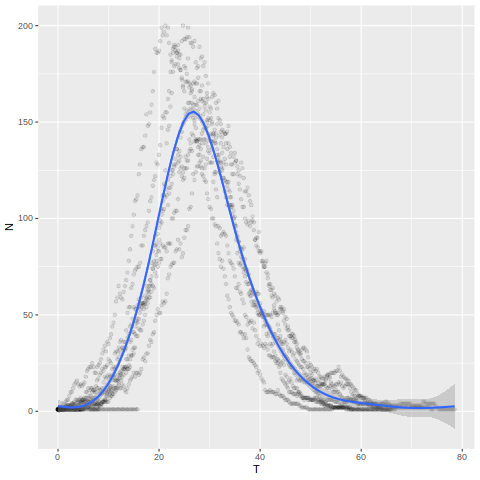

In [53]:
%%R -i all_sims

library(tidyverse)
library(plotly)

fig_plt <- all_sims %>% filter(InfState == "I") %>% ggplot(aes(x=T, y=N)) +
    geom_point(alpha=.1) +
    geom_smooth()



fig_plt



## Adding an Stochastic Observation Process to a Determinsitic Model

We can add a stochstic observation process to a deterministic (or stochastic) model. First we add the observation column to the population, than create an epi model with blended stochastic and deterministic rules. 

In [54]:
#Creeate a hospitalization column with everyone unobserved
population['Hosp'] = 'U'

#Create the hospitalization rule. Everyone has a 5% chance of being hospitalized per day infected
hosp_rule = tepi.SimpleObservationProcess(source_col="InfState",source_state="I", obs_col="Hosp", rate=.05, stochastic=True)

#Make the epi 
hosp_obs_mdl = tepi.EpiModel(init_state = population, rules = [
    [infect_rule, recover_rule],
    [hosp_rule]
])


for i in range(400):
    hosp_obs_mdl.do_timestep(dt=0.25)

hosp_res = hosp_obs_mdl.full_epi

Note that when we plot infections we need to take into account the various observed states. Very easy with tidyverse.

/home/justin/anaconda3/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame


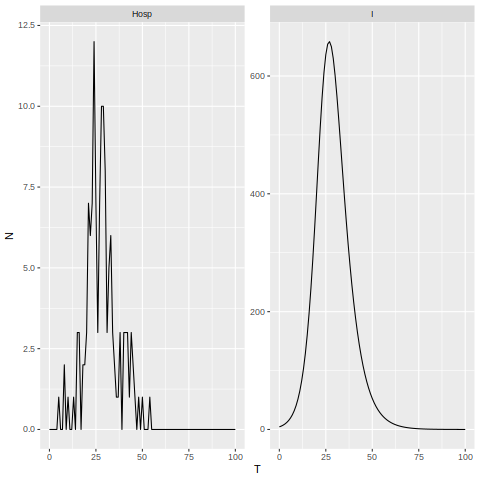

In [55]:
%%R -i hosp_res


dly_hosp <- hosp_res %>% mutate(T=floor(T))%>%
    group_by(T)%>%
    summarize(Hosp=sum(N*(Hosp=="I")),
              I = sum(N*(InfState=="I")))%>%
    ungroup()

dly_hosp %>% pivot_longer(cols=c(Hosp,I), names_to="name", values_to="N") %>%
    ggplot(aes(x=T, y=N)) + geom_line() + facet_wrap(~name, scales="free_y")